# Unsupervised classification of Yahoo! Answers dataset

In the ages of raising influence of various AIs, datascience is up to solutions of many real application problems. Problem of understanding what is in the data have become important part of this process. Having clean dataset is half of the success, then training of the either simple machine learning model or maybe even advanced neural network is the easy part. In the document we would like to address interesting problem of unsupervised semantic text classification. Data is lies everywhere around us, scraping of web or text documents is straight way how to collect data. But data itself is worthless unless we understand what is hidden inside. There could happen many situation when classification of huge volume of text data is needed. This could be addressed by manual labeling of some part of the dataset and then model training. However this approach take some time and manual work. Trying to avoid unnecessary manual work we have to sail through dangerous and uncharted waters of unsupervised modelling. One of the new and very promissing models able to perform unsupervised classification is called lbl2vec. For curious readers in this link can be found recent white paper where lbl2vec is compared with other unsupervised model. Paper can be downloaded through this [link](https://arxiv.org/pdf/2211.16285.pdf). In this paper it was discovered that lbl2vec has superior results over other available unsupervised methods. In this document I will try to reconstruct same process that was described in paper and compare it with my new experimental design.

## Classification as described in paper

Authors of paper used 4 text classification datasets to demonstrate capabilities of unsupervised methods. For this experiment I've selected Yahoo! Answers dataset because classification of this dataset has the worst results out of these 4 datasets. Classification of this dataset seems most challenging, let's see how we will cope with this task.

### Dataset

First we should take a look to dataset. It can be downloaded from this [link](https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M).

Whole dataset has 1.46 milion records and contain 4 columns (class, title, question, answer). Column class represents label for each of answers, it has 10 classes: Society & Culture, Science & Mathematics, Health, Education & Reference, Computers & Internet, Sports, Business & Finance, Entertainment & Music, Family & Relationships, Politics & Government.

As it is stated in the paper we don't need to split data to train and test, since this is unsupervised model we don't need to have part of data for validation. Also some answers were empty or contain just simple statement such as yes or no as answer. We will drop empty and 1 word answers from dataset as it was done in the paper. 

Because of longer computational time in this showcase we will be working with reduced dataset with 100000 of randomly selected records.

In [2]:
import pandas as pd
# we will start with loading of data
df_yahoo = pd.read_csv("data/train.csv", names=["class", "title", "question", "answer"])
df_yahoo = df_yahoo.append(pd.read_csv("data//test.csv", names=["class", "title", "question", "answer"]),ignore_index=True)

# and clean data by excluding empty and 1 word answers
df_yahoo = df_yahoo[df_yahoo.answer.str.len() > 0]
word_counts = df_yahoo["answer"].str.split().str.len()
df_yahoo = df_yahoo[word_counts > 1]

# randomly select 100000 data sample to speed up calculations
df_yahoo_reduced = df_yahoo.sample(n=10**5, replace=False, random_state=123)

### Class definitions

At this point dataset is ready for classification. Now we need to do preparation for model fitting. Lbl2vec approach is unsupervised classification which requires keyword representation of classes, then fitted model could calculate similarity for each described class and select most similar class for classified document. Keywords used for classification in the paper are simply derived from class names.

In [3]:
keywords_dict = {
    "Society & Culture": [
        ['society', 'culture'],
    ],
    "Science & Mathematics": [
        ['science', 'mathematics'],
    ],
    "Health": [
        ['health'],
    ], 
    "Education & Reference": [
        ['education', 'reference'],
    ],
    "Computers & Internet": [
        ['computers', 'internet'],
    ],
    "Sports": [
        ['sports'], 
    ],
    "Business & Finance": [
        ['business', 'finance'],
    ], 
    "Entertainment & Music": [
        ['entertainment', 'music'],
    ],
    "Family & Relationships": [
        ['family', 'relationships'],
    ],
    "Politics & Government": [
        ['politics', 'government'],
    ],
}

### Model

Now we have all that's needed to replicate approach used in paper. Let's fit model and classify data!

In [3]:
# I've wrapped all needed functionality to Textclassifier 
from classification_with_lbl2vec import Textclassifier

# initialize classifier
classifier = Textclassifier(data=df_yahoo_reduced["answer"].to_list(), classes=list(keywords_dict.keys()), keywords_dict=keywords_dict)

# train model
classifier.train_model()

/Users/mariomitas/Documents/GitHub/unsupervised_text_classification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-05 12:25:57,553 - Lbl2Vec - INFO - Train document and word embeddings
2023-05-05 12:28:23,523 - Lbl2Vec - INFO - Train label embeddings


In [4]:
# label whole dataset
df_classified = classifier.classify_data()

2023-05-05 12:28:24,826 - Lbl2Vec - INFO - Get document embeddings from model
2023-05-05 12:28:24,878 - Lbl2Vec - INFO - Calculate document<->label similarities




### Results

Results stated in the paper shows F1 score for pure lbl2vec equal to 0.4426, now we can compare this result with our experiment.


In [5]:
from sklearn.metrics import f1_score

predicted_class = df_classified["predicted_class"]
actual_class = df_yahoo_reduced["class"]

print("F1 score:", f1_score(actual_class, predicted_class, average="micro"))

F1 score: 0.46259



This result is similar to result in paper (44.26), but we won't be satisfied with this baseline accuracy. We will try to improve these results.

## Keywords tuning approach

Representation of keywords for classes in paper was done very simply by using words from class names and as we saw this worked just fine, but here are some questions that raised from this. How does results change with different keywords? How to select better keywords?

Another note is that in this case classes present in dataset were clearly defined. However, it may happen that poor data scientinst just start with data exploration and have no idea about classes in data. 

Both of these challenges can be addressed with some additional effort.

### Clustering

Clustering is simple unsupervised learning technique, it can be applied to many different issues and it could give answers also in this case. We can try to cluster texts and review words closest to centroids. This might help us to determine classes if wouldn't know what are the casses, but in this case we review words to determine better keywords for already established classes.
First we need to vectorize texts then perform clustering and find closest words to the centroids of clusters. After that we can review keywords and select the ones that define best our classes.

In [6]:
# we will initialize Textclassifier but this time we don't provide keywords
classifier_tuning = Textclassifier(data=df_yahoo_reduced["answer"].to_list(), classes=list(keywords_dict.keys()))

# instead we will cluster words with kmeans and examine 10 closest words to each centroid
# 100 sets of keywords will be presented to us and we will have to link keywords with class by prompt selection
classifier_tuning.find_keywords(model="Kmeans", k_clusters=100, n_keywords=10, random_seed=123)

['little', 'bit', 'think', 'like', 'time', 'know', 'don', 'girl', 'good', 'try']
Please choose one of these options:
0.) Drop keywords
1.) Society & Culture
2.) Science & Mathematics
3.) Health
4.) Education & Reference
5.) Computers & Internet
6.) Sports
7.) Business & Finance
8.) Entertainment & Music
9.) Family & Relationships
10.) Politics & Government


### Class definitions

We've carefully selected some of the presented sets of keywords to be suitable to represent one of the classes. Now we can review all selected keywords.

In [7]:
for clss in classifier_tuning.keywords_dict:
    print(f"Class: {clss}")
    for index, keywordset in enumerate(classifier_tuning.keywords_dict[clss]):
        print(f"Keword set {index}:", keywordset)
    print("*" * 80)

Class: Society & Culture
Keword set 0: ['jesus', 'christ', 'god', 'bible', 'lord', 'church', 'heaven', 'believe', 'life', 'father']
Keword set 1: ['english', 'language', 'speak', 'spanish', 'learn', 'languages', 'speaking', 'french', 'words', 'people']
Keword set 2: ['god', 'bible', 'believe', 'bless', 'jesus', 'people', 'pray', 'created', 'man', 'love']
********************************************************************************
Class: Science & Mathematics
Keword set 0: ['air', 'pressure', 'force', 'oxygen', 'temperature', 'water', 'heat', 'like', 'lungs', 'gas']
Keword set 1: ['water', 'salt', 'drink', 'warm', 'oxygen', 'body', 'hydrogen', 'pressure', 'heat', 'drinking']
Keword set 2: ['light', 'speed', 'blue', 'sun', 'black', 'sky', 'wavelength', 'red', 'color', 'mass']
Keword set 3: ['earth', 'moon', 'sun', 'planet', 'gravity', 'planets', 'orbit', 'solar', 'surface', 'space']
Keword set 4: ['energy', 'heat', 'kinetic', 'mass', 'electrons', 'potential', 'oxygen', 'reaction', 'a

In [3]:
keywords_dict_tuned = {"Society & Culture": [['jesus', 'christ', 'god', 'bible', 'lord', 'church', 'heaven', 'believe', 'life', 'father'],
                                             ['english', 'language', 'speak', 'spanish', 'learn', 'languages', 'speaking', 'french', 'words', 'people'],
                                             ['god', 'bible', 'believe', 'bless', 'jesus', 'people', 'pray', 'created', 'man', 'love']],
                 "Science & Mathematics": [['air', 'pressure', 'force', 'oxygen', 'temperature', 'water', 'heat', 'like', 'lungs', 'gas'],
                                           ['water', 'salt', 'drink', 'warm', 'oxygen', 'body', 'hydrogen', 'pressure', 'heat', 'drinking'],
                                           ['light', 'speed', 'blue', 'sun', 'black', 'sky', 'wavelength', 'red', 'color', 'mass'],
                                           ['earth', 'moon', 'sun', 'planet', 'gravity', 'planets', 'orbit', 'solar', 'surface', 'space'],
                                           ['energy', 'heat', 'kinetic', 'mass', 'electrons', 'potential', 'oxygen', 'reaction', 'atoms', 'electron']],
                 "Health": [['food', 'eat', 'eating', 'like', 'fast', 'foods', 'water', 'junk', 'people', 'health'],
                            ['doctor', 'ask', 'best', 'need', 'blood', 'don', 'medication', 'infection', 'check', 'medical'],
                            ['weight', 'fat', 'lose', 'exercise', 'diet', 'calories', 'body', 'muscle', 'gain', 'eat'],
                            ['eat', 'exercise', 'eating', 'day', 'fat', 'diet', 'healthy', 'foods', 'don', 'weight'],
                            ['pain', 'symptoms', 'cause', 'doctor', 'feel', 'help', 'time', 'infection', 'good', 'treatment']],
                 "Education & Reference": [['learn', 'learning', 'help', 'spell', 'time', 'language', 'people', 'like', 'things', 'know'],
                                           ['school', 'high', 'college', 'schools', 'students', 'good', 'work', 'education', 'scholarships', 'don'],
                                           ['question', 'education', 'answer', 'needs', 'special', 'answered', 'good', 'received', 'parenting', 'refers'],
                                           ['means', 'word', 'idea', 'words', 'meaning', 'use', 'think', 'like', 'latin', 'don']],
                 "Computers & Internet": [['windows', 'software', 'install', 'program', 'programs', 'spyware', 'run', 'microsoft', 'computer', 'virus'],
                                          ['free', 'download', 'limewire', 'software', 'try', 'music', 'search', 'use', 'virus', 'program'],
                                          ['email', 'address', 'send', 'yahoo', 'account', 'spam', 'want', 'll', 'ask', 'emails'],
                                          ['file', 'files', 'open', 'program', 'save', 'click', 'download', 'use', 'folder', 'format'],
                                          ['click', 'right', 'select', 'tab', 'page', 'box', 'button', 'menu', 'properties', 'delete'],
                                          ['mail', 'yahoo', 'send', 'address', 'outlook', 'click', 'spam', 'email', 'server', 'account'],
                                          ['drive', 'hard', 'disk', 'files', 'drives', 'dvd', 'windows', 'install', 'boot', 'cd'],
                                          ['com', 'www', 'try', 'search', 'check', 'amazon', 'youtube', 'download', 'free', 'yahoo']],
                 "Sports": [['team', 'win', 'players', 'game', 'teams', 'player', 'play', 'best', 'year', 'think'],
                            ['play', 'game', 'games', 'like', 'ball', 'player', 'playing', 'football', 'players', 'don'],
                            ['world', 'cup', 'win', 'brazil', 'think', 'won', 'best', 'people', 'germany', 'like']],
                 "Business & Finance": [['money', 'people', 'need', 'buy', 'bank', 'spend', 'like', 'work', 'don', 'account'],
                                        ['pay', 'taxes', 'money', 'tax', 'loan', 'paid', 'don', 'people', 'work', 'attention'],
                                        ['business', 'grants', 'businesses', 'grant', 'plan', 'small', 'start', 'home', 'need', 'information'],
                                        ['price', 'ebay', 'sell', 'buy', 'prices', 'market', 'pay', 'cost', 'stock', 'good'],
                                        ['company', 'insurance', 'companies', 'work', 'stock', 'business', 'know', 'like', 'want', 'need'],
                                        ['card', 'credit', 'cards', 'video', 'report', 'score', 'debt', 'pay', 'need', 'bank']],
                 "Entertainment & Music": [['book', 'read', 'books', 'good', 'movie', 'library', 'like', 'think', 'know', 'try'],
                                           ['song', 'lyrics', 'love', 'called', 'like', 'music', 'good', 'songs', 'album', 'think']],
                 "Family & Relationships": [['sex', 'having', 'want', 'like', 'think', 'don', 'love', 'time', 'women', 'sexual'],
                                            ['baby', 'child', 'pregnant', 'mother', 'girl', 'like', 'don', 'way', 'love', 'birth'],
                                            ['guys', 'like', 'girls', 'guy', 'girl', 'don', 'know', 'think', 'women', 'good']],
                 "Politics & Government": [['court', 'case', 'supreme', 'judge', 'child', 'order', 'lawyer', 'attorney', 'legal', 'state'],
                                           ['law', 'legal', 'laws', 'state', 'enforcement', 'need', 'federal', 'attorney', 'states', 'rights'],
                                           ['born', 'citizen', 'years', 'birth', 'president', 'citizenship', 'people', 'don', 'know', 'american'],
                                           ['war', 'iraq', 'bush', 'people', 'world', 'civil', 'president', 'american', 'troops', 'iran'],
                                           ['state', 'states', 'local', 'department', 'federal', 'laws', 'contact', 'depends', 'license', 'county']]}

As we can see we have at least three keyword sets connected with each class. We can use these keywords to build model and label data, hopefully we will notice some improvements with these new keywords.

In [14]:
classifier_tuning.train_model()
df_classified_tuned = classifier_tuning.classify_data()

actual_class = df_yahoo_reduced["class"]
predicted_class = df_classified_tuned["predicted_class"]

2023-05-05 13:23:59,011 - Lbl2Vec - INFO - Train document and word embeddings
2023-05-05 13:23:59,011 - Lbl2Vec - INFO - Train document and word embeddings
2023-05-05 13:23:59,011 - Lbl2Vec - INFO - Train document and word embeddings
2023-05-05 13:23:59,011 - Lbl2Vec - INFO - Train document and word embeddings
2023-05-05 13:26:24,442 - Lbl2Vec - INFO - Train label embeddings
2023-05-05 13:26:24,442 - Lbl2Vec - INFO - Train label embeddings
2023-05-05 13:26:24,442 - Lbl2Vec - INFO - Train label embeddings
2023-05-05 13:26:24,442 - Lbl2Vec - INFO - Train label embeddings
2023-05-05 13:26:31,405 - Lbl2Vec - INFO - Get document embeddings from model
2023-05-05 13:26:31,405 - Lbl2Vec - INFO - Get document embeddings from model
2023-05-05 13:26:31,405 - Lbl2Vec - INFO - Get document embeddings from model
2023-05-05 13:26:31,405 - Lbl2Vec - INFO - Get document embeddings from model
2023-05-05 13:26:31,459 - Lbl2Vec - INFO - Calculate document<->label similarities
2023-05-05 13:26:31,459 - Lbl

F1 score: 0.48486


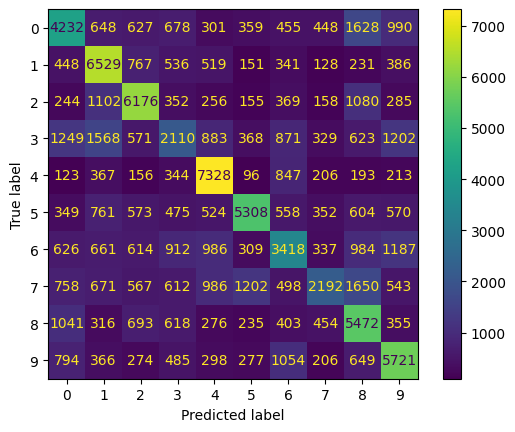

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print("F1 score:", f1_score(actual_class, predicted_class, average="micro"))

plt.rcParams['axes.grid'] = False

confusion_matrix = confusion_matrix(actual_class, predicted_class)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, )

cm_display.plot()
plt.show()

F1 score with new keywords is better, this means that tuning of keywords have some positive impact on classification results. With a little additional work connected with sorting proposed keywords we were able to achvieve f1 score improvement above 0.02. Now imagine that we wouldn't even had information what classes are in the data. The proposed keywords would be helpful to sort it out and establish classes presented in our data. Just by looking at the keywords we could form similar classes as it was already attached to data.

## Lbl2TransformerVec

This method is very similar to lbl2vec, only difference is that we won't use doc2vec to learn word and document representations as it is used in lbl2vec. We will use SBERT models which had best accuracy with classification of Yahoo! Answers dataset (simpler SBERT had 0.5287 and more advanced had 0.5584 f1 scores).

### Simple SBERT model

In [3]:
from classification_with_lbl2vec import Textclassifier

# initialize classifier
transformer_classifier = Textclassifier(data=df_yahoo_reduced["answer"].to_list(), classes=list(keywords_dict.keys()), keywords_dict=keywords_dict)

# train model
transformer_classifier.train_model(transformer=True, transformer_model=None)  # using all-MiniLM-L6-v2 sentence transformer

df_transformer_classified = transformer_classifier.classify_data()

# add real classes into dataframe
df_transformer_classified.reset_index(drop=True, inplace=True)
df_transformer_classified.reset_index(drop=True, inplace=True)
df_transformer_classified["actual_class"] = df_yahoo_reduced["class"]

/Users/mariomitas/Documents/GitHub/unsupervised_text_classification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-05 23:06:40,461 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2023-05-05 23:06:40,644 - Lbl2TransformerVec - INFO - Compute document embeddings
2023-05-05 23:47:25,205 - Lbl2TransformerVec - INFO - Train label embeddings
2023-05-05 23:47:36,770 - Lbl2TransformerVec - INFO - Get document embeddings from model
2023-05-05 23:47:36,770 - Lbl2TransformerVec - INFO - Calculate document<->label similarities


F1 score: 0.50902


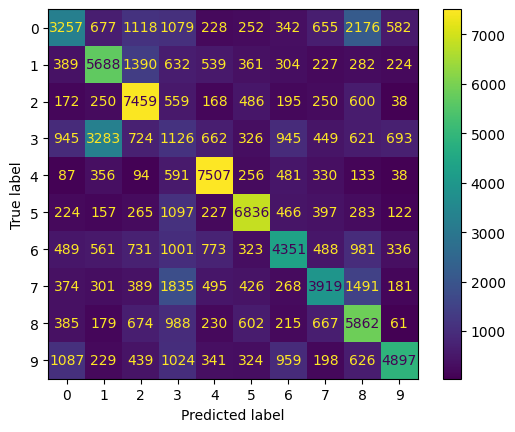

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

actual_class = df_yahoo_reduced["class"]
predicted_class = df_transformer_classified["predicted_class"]
print("F1 score:", f1_score(actual_class, predicted_class, average="micro"))

plt.rcParams['axes.grid'] = False

confusion_matrix = confusion_matrix(actual_class, predicted_class)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, )

cm_display.plot()
plt.show()

This time we've used the same keywords as in paper, result with this data sample is slightly worse than paper's score with whole dataset (0.50902 vs 0.5287), however it is still better than "non-transformer" model. Now let's see if our tuned keywords would improve results.

In [5]:
from classification_with_lbl2vec import Textclassifier

# initialize classifier
transformer_classifier = Textclassifier(data=df_yahoo_reduced["answer"].to_list(), classes=list(keywords_dict_tuned.keys()), keywords_dict=keywords_dict_tuned)

# train model
transformer_classifier.train_model(transformer=True, transformer_model=None)

df_transformer_classified = transformer_classifier.classify_data()

# add real classes into dataframe
df_transformer_classified.reset_index(drop=True, inplace=True)
df_transformer_classified.reset_index(drop=True, inplace=True)
df_transformer_classified["actual_class"] = df_yahoo_reduced["class"]

2023-05-06 10:22:26,018 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2023-05-06 10:22:29,534 - Lbl2TransformerVec - INFO - Compute document embeddings
2023-05-06 11:00:59,378 - Lbl2TransformerVec - INFO - Train label embeddings
2023-05-06 11:01:47,103 - Lbl2TransformerVec - INFO - Get document embeddings from model
2023-05-06 11:01:47,103 - Lbl2TransformerVec - INFO - Calculate document<->label similarities


F1 score: 0.47216


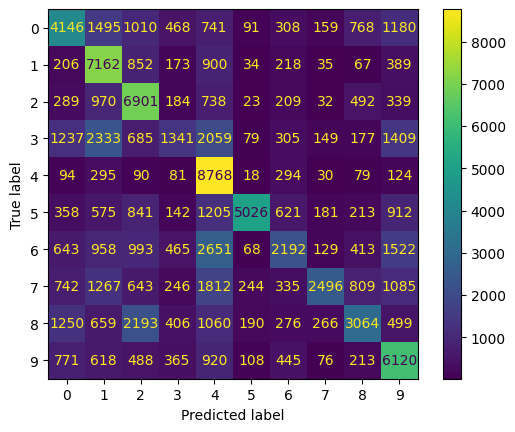

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

actual_class = df_yahoo_reduced["class"]
predicted_class = df_transformer_classified["predicted_class"]
print("F1 score:", f1_score(actual_class, predicted_class, average="micro"))

plt.rcParams['axes.grid'] = False

confusion_matrix = confusion_matrix(actual_class, predicted_class)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, )

cm_display.plot()
plt.show()

Unlike with non-transformer model it seems that keywords obtained with k-means did reduce accuracy. We can try also more powerfull SBERT transformer model to compare it with these results.

### Advanced SBERT model

In [8]:
from classification_with_lbl2vec import Textclassifier

# initialize classifier
transformer_classifier = Textclassifier(data=df_yahoo_reduced["answer"].to_list(), classes=list(keywords_dict.keys()), keywords_dict=keywords_dict)

# train model
transformer_classifier.train_model(transformer=True, transformer_model="SBERT")

df_transformer_classified = transformer_classifier.classify_data()

# add real classes into dataframe
df_transformer_classified.reset_index(drop=True, inplace=True)
df_transformer_classified.reset_index(drop=True, inplace=True)
df_transformer_classified["actual_class"] = df_yahoo_reduced["class"]

2023-05-06 11:04:19,554 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2023-05-06 11:04:19,554 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2023-05-06 11:04:20,344 - Lbl2TransformerVec - INFO - Compute document embeddings
2023-05-06 11:04:20,344 - Lbl2TransformerVec - INFO - Compute document embeddings
2023-05-06 14:12:05,776 - Lbl2TransformerVec - INFO - Train label embeddings
2023-05-06 14:12:05,776 - Lbl2TransformerVec - INFO - Train label embeddings
2023-05-06 14:12:18,359 - Lbl2TransformerVec - INFO - Get document embeddings from model
2023-05-06 14:12:18,359 - Lbl2TransformerVec - INFO - Get document embeddings from model
2023-05-06 14:12:18,360 - Lbl2TransformerVec - INFO - Calculate document<->label similarities
2023-05-06 14:12:18,360 - Lbl2TransformerVec - INFO - Calculate document<->label similarities


F1 score: 0.54717


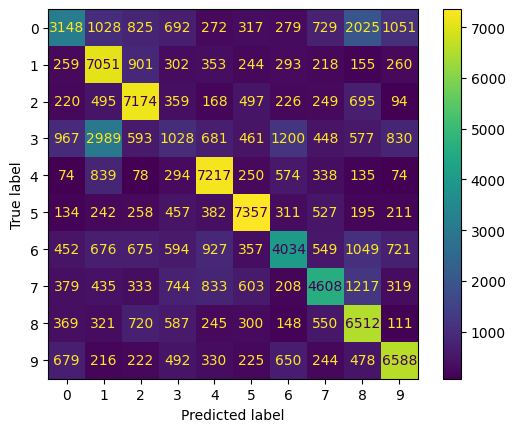

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

actual_class = df_yahoo_reduced["class"]
predicted_class = df_transformer_classified["predicted_class"]
print("F1 score:", f1_score(actual_class, predicted_class, average="micro"))

plt.rcParams['axes.grid'] = False

confusion_matrix = confusion_matrix(actual_class, predicted_class)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, )

cm_display.plot()
plt.show()

Using keywords from paper we can see that more advanced transformer model have better score than simple model. Now we can test our tuned keywords.

In [4]:
from classification_with_lbl2vec import Textclassifier

# initialize classifier
transformer_classifier = Textclassifier(data=df_yahoo_reduced["answer"].to_list(), classes=list(keywords_dict.keys()), keywords_dict=keywords_dict_tuned)

# train model
transformer_classifier.train_model(transformer=True, transformer_model="SBERT")

df_transformer_classified = transformer_classifier.classify_data()

/Users/mariomitas/Documents/GitHub/unsupervised_text_classification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-09 15:01:50,121 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2023-05-09 15:02:08,402 - Lbl2TransformerVec - INFO - Compute document embeddings
2023-05-09 18:01:35,286 - Lbl2TransformerVec - INFO - Train label embeddings
2023-05-09 18:02:25,302 - Lbl2TransformerVec - INFO - Get document embeddings from model
2023-05-09 18:02:25,303 - Lbl2TransformerVec - INFO - Calculate document<->label similarities


F1 score: 0.50643


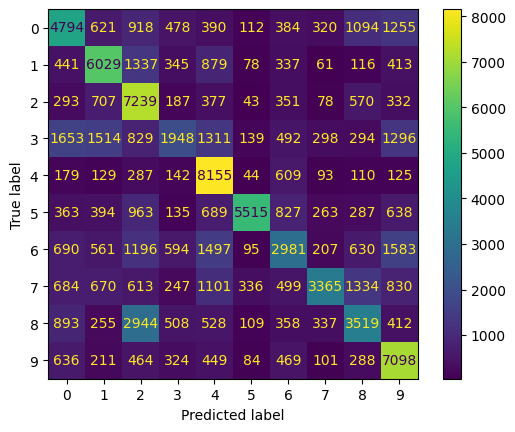

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

actual_class = df_yahoo_reduced["class"]
predicted_class = df_transformer_classified["predicted_class"]
print("F1 score:", f1_score(actual_class, predicted_class, average="micro"))

plt.rcParams['axes.grid'] = False

confusion_matrix = confusion_matrix(actual_class, predicted_class)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, )

cm_display.plot()
plt.show()

And once again k-mean keywords have worse accuracy than keywords used in paper. Just to summarize our observations, keywords obtained by k-means method improved results of non-transformer model but for transformer models it had oposite reaction with slightly worse results.

### Keywords Tuning

In this section we will try to determine what is wrong with keywords. Now we should carefully review keywords.

In [ ]:
keywords_dict_tuned = {"Society & Culture": [['jesus', 'christ', 'god', 'bible', 'lord', 'church', 'heaven', 'believe', 'life', 'father'],
                                             ['english', 'language', 'speak', 'spanish', 'learn', 'languages', 'speaking', 'french', 'words', 'people'],
                                             ['god', 'bible', 'believe', 'bless', 'jesus', 'people', 'pray', 'created', 'man', 'love']],
                 "Science & Mathematics": [['air', 'pressure', 'force', 'oxygen', 'temperature', 'water', 'heat', 'like', 'lungs', 'gas'],
                                           ['water', 'salt', 'drink', 'warm', 'oxygen', 'body', 'hydrogen', 'pressure', 'heat', 'drinking'],
                                           ['light', 'speed', 'blue', 'sun', 'black', 'sky', 'wavelength', 'red', 'color', 'mass'],
                                           ['earth', 'moon', 'sun', 'planet', 'gravity', 'planets', 'orbit', 'solar', 'surface', 'space'],
                                           ['energy', 'heat', 'kinetic', 'mass', 'electrons', 'potential', 'oxygen', 'reaction', 'atoms', 'electron']],
                 "Health": [['food', 'eat', 'eating', 'like', 'fast', 'foods', 'water', 'junk', 'people', 'health'],
                            ['doctor', 'ask', 'best', 'need', 'blood', 'don', 'medication', 'infection', 'check', 'medical'],
                            ['weight', 'fat', 'lose', 'exercise', 'diet', 'calories', 'body', 'muscle', 'gain', 'eat'],
                            ['eat', 'exercise', 'eating', 'day', 'fat', 'diet', 'healthy', 'foods', 'don', 'weight'],
                            ['pain', 'symptoms', 'cause', 'doctor', 'feel', 'help', 'time', 'infection', 'good', 'treatment']],
                 "Education & Reference": [['learn', 'learning', 'help', 'spell', 'time', 'language', 'people', 'like', 'things', 'know'],
                                           ['school', 'high', 'college', 'schools', 'students', 'good', 'work', 'education', 'scholarships', 'don'],
                                           ['question', 'education', 'answer', 'needs', 'special', 'answered', 'good', 'received', 'parenting', 'refers'],
                                           ['means', 'word', 'idea', 'words', 'meaning', 'use', 'think', 'like', 'latin', 'don']],
                 "Computers & Internet": [['windows', 'software', 'install', 'program', 'programs', 'spyware', 'run', 'microsoft', 'computer', 'virus'],
                                          ['free', 'download', 'limewire', 'software', 'try', 'music', 'search', 'use', 'virus', 'program'],
                                          ['email', 'address', 'send', 'yahoo', 'account', 'spam', 'want', 'll', 'ask', 'emails'],
                                          ['file', 'files', 'open', 'program', 'save', 'click', 'download', 'use', 'folder', 'format'],
                                          ['click', 'right', 'select', 'tab', 'page', 'box', 'button', 'menu', 'properties', 'delete'],
                                          ['mail', 'yahoo', 'send', 'address', 'outlook', 'click', 'spam', 'email', 'server', 'account'],
                                          ['drive', 'hard', 'disk', 'files', 'drives', 'dvd', 'windows', 'install', 'boot', 'cd'],
                                          ['com', 'www', 'try', 'search', 'check', 'amazon', 'youtube', 'download', 'free', 'yahoo']],
                 "Sports": [['team', 'win', 'players', 'game', 'teams', 'player', 'play', 'best', 'year', 'think'],
                            ['play', 'game', 'games', 'like', 'ball', 'player', 'playing', 'football', 'players', 'don'],
                            ['world', 'cup', 'win', 'brazil', 'think', 'won', 'best', 'people', 'germany', 'like']],
                 "Business & Finance": [['money', 'people', 'need', 'buy', 'bank', 'spend', 'like', 'work', 'don', 'account'],
                                        ['pay', 'taxes', 'money', 'tax', 'loan', 'paid', 'don', 'people', 'work', 'attention'],
                                        ['business', 'grants', 'businesses', 'grant', 'plan', 'small', 'start', 'home', 'need', 'information'],
                                        ['price', 'ebay', 'sell', 'buy', 'prices', 'market', 'pay', 'cost', 'stock', 'good'],
                                        ['company', 'insurance', 'companies', 'work', 'stock', 'business', 'know', 'like', 'want', 'need'],
                                        ['card', 'credit', 'cards', 'video', 'report', 'score', 'debt', 'pay', 'need', 'bank']],
                 "Entertainment & Music": [['book', 'read', 'books', 'good', 'movie', 'library', 'like', 'think', 'know', 'try'],
                                           ['song', 'lyrics', 'love', 'called', 'like', 'music', 'good', 'songs', 'album', 'think']],
                 "Family & Relationships": [['sex', 'having', 'want', 'like', 'think', 'don', 'love', 'time', 'women', 'sexual'],
                                            ['baby', 'child', 'pregnant', 'mother', 'girl', 'like', 'don', 'way', 'love', 'birth'],
                                            ['guys', 'like', 'girls', 'guy', 'girl', 'don', 'know', 'think', 'women', 'good']],
                 "Politics & Government": [['court', 'case', 'supreme', 'judge', 'child', 'order', 'lawyer', 'attorney', 'legal', 'state'],
                                           ['law', 'legal', 'laws', 'state', 'enforcement', 'need', 'federal', 'attorney', 'states', 'rights'],
                                           ['born', 'citizen', 'years', 'birth', 'president', 'citizenship', 'people', 'don', 'know', 'american'],
                                           ['war', 'iraq', 'bush', 'people', 'world', 'civil', 'president', 'american', 'troops', 'iran'],
                                           ['state', 'states', 'local', 'department', 'federal', 'laws', 'contact', 'depends', 'license', 'county']]}

Each set of keywords is as it was obtained from k-means, so it is 10 words closest to centroid. Good example is second keyword set for culture:

['english', 'language', 'speak', 'spanish', 'learn', 'languages', 'speaking', 'french', 'words', 'people']

These keywords clearly refer to english and foreign languages, these 10 keywords seem to allign well, but if we look close to each particular word alone each of them aren't specific to topic. We can identify more general words as people or speak/speaking, although it can be used for language topic words like these can be used in many different situations not only in this topic. I would say that having these more general words in keywords sets could be similar to adding noise into model, this would explain the fact that performance of simple model was improve and more sophisticated models had degraded performance due to overfitting noisy keywords. We can try reduce keywords in each set to be more homogenous accross each other and with pointing strictly to the topic.

Our first tuning experiment:

In [9]:
keywords_dict_tuned2 = {"Society & Culture": [['jesus', 'christ', 'god', 'bible', 'lord', 'church', 'heaven'],
                                              ['language', 'spanish', 'french'],],
                 "Science & Mathematics": [['force', 'oxygen', 'temperature', 'heat', 'gas'],
                                           ['water', 'air', 'salt', 'oxygen','hydrogen'],
                                           ['light', 'speed', 'sun', 'wavelength'],
                                           ['earth', 'moon', 'sun', 'planet', 'gravity', 'orbit', 'solar', 'surface', 'space'],
                                           ['energy', 'heat', 'kinetic', 'mass', 'electrons', 'reaction', 'atoms', 'electron']],
                 "Health": [['food', 'eat', 'fast', 'junk', 'health'],
                            ['doctor', 'blood', 'medication', 'infection', 'check', 'medical'],
                            ['weight', 'fat', 'exercise', 'diet', 'calories', 'body', 'muscle', 'eat'],
                            ['pain', 'symptoms', 'cause', 'doctor', 'infection', 'treatment']],
                 "Education & Reference": [['learn', 'spell', 'language'],
                                           ['school', 'college', 'students', 'education', 'scholarships'],
                                           ['question', 'education', 'answer', 'parenting', 'refers'],
                                           ['means', 'word', 'idea', 'meaning']],
                 "Computers & Internet": [['windows', 'software', 'install', 'program', 'spyware', 'microsoft', 'computer'],
                                          ['download', 'limewire', 'software', 'virus', 'program'],
                                          ['email', 'address', 'send', 'yahoo', 'account', 'spam', 'server'],
                                          ['file', 'program', 'save', 'click', 'folder', 'format'],
                                          ['com', 'www', 'try', 'amazon', 'youtube', 'yahoo']],
                 "Sports": [['team', 'win', 'game', 'player', 'play'],
                            ['play', 'game', 'ball', 'football'],
                            ['world', 'cup', 'win']],
                 "Business & Finance": [['money', 'buy', 'bank', 'spend', 'account'],
                                        ['pay', 'taxes', 'money', 'tax', 'loan'],
                                        ['price', 'ebay', 'sell', 'buy', 'market', 'cost', 'stock'],
                                        ['company', 'insurance', 'work', 'stock', 'business'],
                                        ['card', 'credit', 'debt', 'pay', 'bank']],
                 "Entertainment & Music": [['book', 'read', 'movie', 'library'],
                                           ['song', 'lyrics', 'music', 'album']],
                 "Family & Relationships": [['sex', 'love', 'women', 'sexual'],
                                            ['baby', 'child', 'pregnant', 'mother', 'girl', 'love', 'birth'],
                                            ['like', 'guy', 'girl', 'women']],
                 "Politics & Government": [['court', 'judge', 'lawyer', 'attorney'],
                                           ['law', 'legal', 'rights'],
                                           ['citizen', 'citizenship'],
                                           ['war', 'president', 'troops'],
                                           ['state', 'federal', 'laws', 'county']]}

In [10]:
from classification_with_lbl2vec import Textclassifier

# initialize classifier
transformer_classifier = Textclassifier(data=df_yahoo_reduced["answer"].to_list(), classes=list(keywords_dict.keys()), keywords_dict=keywords_dict_tuned2)

# train model
transformer_classifier.train_model(transformer=True, transformer_model=None)

df_transformer_classified = transformer_classifier.classify_data()

2023-05-10 10:34:13,271 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2023-05-10 10:34:13,271 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2023-05-10 10:34:13,271 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2023-05-10 10:34:14,771 - Lbl2TransformerVec - INFO - Compute document embeddings
2023-05-10 10:34:14,771 - Lbl2TransformerVec - INFO - Compute document embeddings
2023-05-10 10:34:14,771 - Lbl2TransformerVec - INFO - Compute document embeddings
2023-05-10 11:19:53,322 - Lbl2TransformerVec - INFO - Train label embeddings
2023-05-10 11:19:53,322 - Lbl2TransformerVec - INFO - Train label embeddings
2023-05-10 11:19:53,322 - Lbl2TransformerVec - INFO - Train label embeddings
2023-05-10 11:20:35,377 - Lbl2TransformerVec - INFO - Get document embeddings from model
2023-05-10 11:20:35,377 - Lbl2TransformerVec - INFO - Get document embeddings from model
2023-05-10 11:20:35,377 - Lbl2TransformerVec - INFO - Get document embeddings from model
2023-05-10 11

F1 score: 0.5286


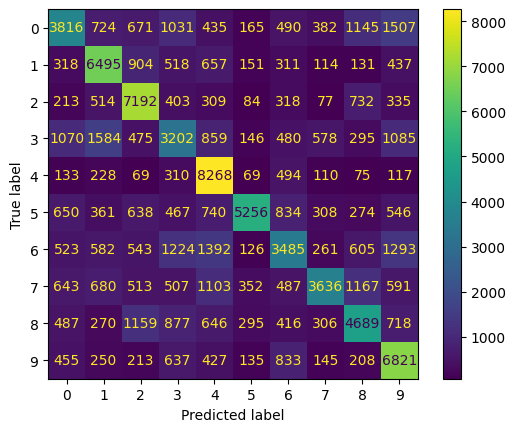

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

actual_class = df_yahoo_reduced["class"]
predicted_class = df_transformer_classified["predicted_class"]
print("F1 score:", f1_score(actual_class, predicted_class, average="micro"))

plt.rcParams['axes.grid'] = False

confusion_matrix = confusion_matrix(actual_class, predicted_class)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, )

cm_display.plot()
plt.show()

In [12]:
from classification_with_lbl2vec import Textclassifier

# initialize classifier
transformer_classifier = Textclassifier(data=df_yahoo_reduced["answer"].to_list(), classes=list(keywords_dict.keys()), keywords_dict=keywords_dict_tuned2)

# train model
transformer_classifier.train_model(transformer=True, transformer_model="SBERT")

df_transformer_classified = transformer_classifier.classify_data()

2023-05-10 11:27:04,998 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2023-05-10 11:27:04,998 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2023-05-10 11:27:04,998 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2023-05-10 11:27:04,998 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2023-05-10 11:27:12,790 - Lbl2TransformerVec - INFO - Compute document embeddings
2023-05-10 11:27:12,790 - Lbl2TransformerVec - INFO - Compute document embeddings
2023-05-10 11:27:12,790 - Lbl2TransformerVec - INFO - Compute document embeddings
2023-05-10 11:27:12,790 - Lbl2TransformerVec - INFO - Compute document embeddings
2023-05-10 14:36:17,647 - Lbl2TransformerVec - INFO - Train label embeddings
2023-05-10 14:36:17,647 - Lbl2TransformerVec - INFO - Train label embeddings
2023-05-10 14:36:17,647 - Lbl2TransformerVec - INFO - Train label embeddings
2023-05-10 14:36:17,647 - Lbl2TransformerVec - INFO - Train label embeddings
2023-05-10 14:37:00,722 - Lbl2Transforme

F1 score: 0.5399


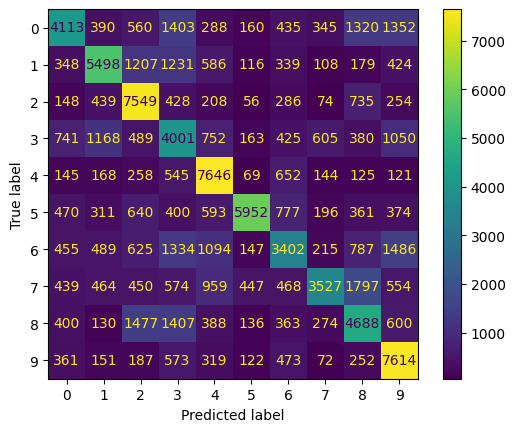

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

actual_class = df_yahoo_reduced["class"]
predicted_class = df_transformer_classified["predicted_class"]
print("F1 score:", f1_score(actual_class, predicted_class, average="micro"))

plt.rcParams['axes.grid'] = False

confusion_matrix = confusion_matrix(actual_class, predicted_class)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, )

cm_display.plot()
plt.show()

With this adjustment both models have much better results. Simple SBERT is better than with paper's keywords and advanced SBERT is just bit worse. Let's reduce keywords even more. We can try to limit each set to maximum 3 keywords, we can separate keywords from each set to more sets with 3 keywords. Also we can add keywords from paper as well. 

Now dict with keywords look like this:

In [4]:
keywords_dict_tuned3 = {"Society & Culture": [['god', 'bible', 'church'],
                                              ['language', 'spanish', 'french'],
                                              ['society', 'culture']],
                 "Science & Mathematics": [['force', 'temperature', 'heat'],
                                           ['water', 'air', 'hydrogen'],
                                           ['light', 'speed', 'wavelength'],
                                           ['planet', 'gravity', 'space'],
                                           ['energy', 'heat', 'kinetic'], 
                                           ['mass', 'reaction', 'atoms'],
                                           ['science', 'mathematics']],
                 "Health": [['food', 'eat', 'health'],
                            ['doctor', 'blood', 'medication'],
                            ['weight', 'fat', 'diet'], 
                            ['exercise', 'body', 'muscle'],
                            ['pain', 'symptoms', 'infection'],
                            ['health']],
                 "Education & Reference": [['learn', 'spell', 'language'],
                                           ['school', 'college', 'students'],
                                           ['question', 'education', 'refers'],
                                           ['means', 'word', 'idea'],
                                           ['education', 'reference']],
                 "Computers & Internet": [['software', 'install', 'program'], 
                                          ['spyware', 'microsoft', 'computer'],
                                          ['download', 'virus', 'sofware'],
                                          ['email', 'spam', 'server'],
                                          ['file', 'click', 'folder'],
                                          ['com', 'www', 'internet'], 
                                          ['amazon', 'youtube', 'yahoo'],
                                          ['computers', 'internet']],
                 "Sports": [['team', 'win', 'game'],
                            ['play', 'ball', 'football'],
                            ['world', 'cup', 'win'],
                            ['sports']],
                 "Business & Finance": [['money', 'bank', 'account'],
                                        ['pay', 'taxes', 'loan'],
                                        ['price', 'market', 'stock'],
                                        ['company', 'insurance', 'business'],
                                        ['credit', 'debt', 'pay'],
                                        ['business', 'finance']],
                 "Entertainment & Music": [['book', 'movie', 'library'],
                                           ['song', 'lyrics', 'album'],
                                           ['entertainment', 'music']],
                 "Family & Relationships": [['sex', 'love', 'women'],
                                            ['child', 'pregnant', 'mother'],
                                            ['guy', 'girl', 'women'],
                                            ['family', 'relationships']],
                 "Politics & Government": [['court', 'judge', 'lawyer'],
                                           ['law', 'legal', 'rights'],
                                           ['citizen', 'citizenship', 'american'],
                                           ['war', 'president', 'troops'],
                                           ['state', 'federal', 'county'],
                                           ['politics', 'government']]}

### Non-Transformer model

We can also compare non-transformer model with and without tuned keywords. Although it had slightly worse accuracy this model is fitting much faster then transformer language models which might be the reason to select it if appropriate. Without tuned k-means keywords we achieved f1 score 0.48486

In [15]:
from classification_with_lbl2vec import Textclassifier

# initialize classifier
transformer_classifier = Textclassifier(data=df_yahoo_reduced["answer"].to_list(), classes=list(keywords_dict.keys()), keywords_dict=keywords_dict_tuned3)

# train model
transformer_classifier.train_model()  # ordinary lbl2vec

df_transformer_classified = transformer_classifier.classify_data()

2023-05-10 21:41:22,502 - Lbl2Vec - INFO - Train document and word embeddings
2023-05-10 21:43:37,604 - Lbl2Vec - INFO - Train label embeddings
2023-05-10 21:43:39,653 - Lbl2Vec - WARNING - The following keywords from the 'keywords_list' are unknown to the Doc2Vec model and therefore not used to train the model: sofware
2023-05-10 21:43:43,604 - Lbl2Vec - INFO - Get document embeddings from model
2023-05-10 21:43:43,657 - Lbl2Vec - INFO - Calculate document<->label similarities


F1 score: 0.49853


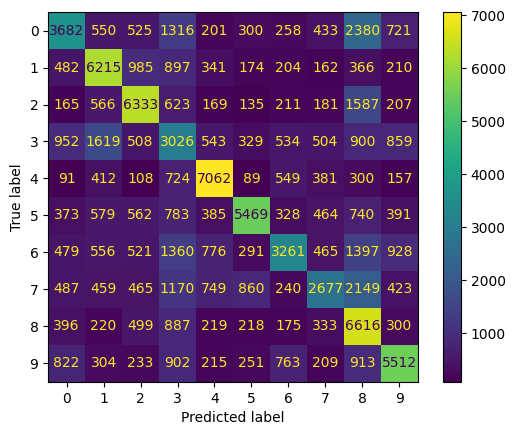

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

actual_class = df_yahoo_reduced["class"]
predicted_class = df_transformer_classified["predicted_class"]
print("F1 score:", f1_score(actual_class, predicted_class, average="micro"))

plt.rcParams['axes.grid'] = False

confusion_matrix = confusion_matrix(actual_class, predicted_class)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, )

cm_display.plot()
plt.show()

# we are trying to beat f1 score 0.48486, which was achieved with unchainged keywords sets

Tuned keywords have better accuracy, now it is very close to score achieved by simple SBERT with paper's keywords (0.50902).

### Simple SBERT model

This model is compromise between fitting time and performance. This model have slightly better accuracy than non-transformer model but it takes much longer to fit (5 minutes vs 40 minutes). Let's see accuracy with tuned keywords.

In [5]:
from classification_with_lbl2vec import Textclassifier

# initialize classifier
transformer_classifier = Textclassifier(data=df_yahoo_reduced["answer"].to_list(), classes=list(keywords_dict.keys()), keywords_dict=keywords_dict_tuned3)

# train model
transformer_classifier.train_model(transformer=True, transformer_model=None)

df_transformer_classified = transformer_classifier.classify_data()

2023-05-10 23:34:05,252 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2023-05-10 23:34:06,524 - Lbl2TransformerVec - INFO - Compute document embeddings
2023-05-11 00:14:34,309 - Lbl2TransformerVec - INFO - Train label embeddings
2023-05-11 00:15:32,500 - Lbl2TransformerVec - INFO - Get document embeddings from model
2023-05-11 00:15:32,500 - Lbl2TransformerVec - INFO - Calculate document<->label similarities


F1 score: 0.54595


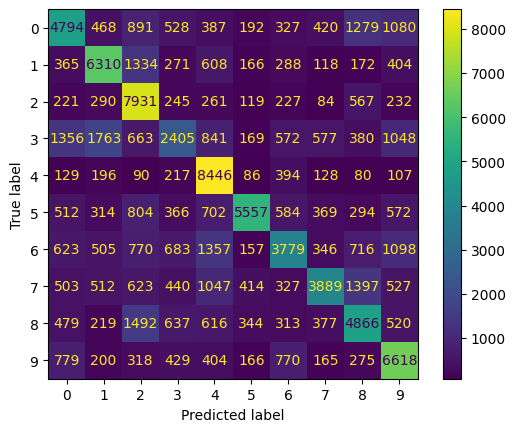

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

actual_class = df_yahoo_reduced["class"]
predicted_class = df_transformer_classified["predicted_class"]
print("F1 score:", f1_score(actual_class, predicted_class, average="micro"))

plt.rcParams['axes.grid'] = False

confusion_matrix = confusion_matrix(actual_class, predicted_class)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, )

cm_display.plot()
plt.show()
# we are trying to beat f1 score 0.5286, which was achieved with unchainged keywords sets

Tuned keywords improved accuracy of simpler SBERT model as well (paper's keywords had 0.50902 f1 score), moreover this f1 score is almost identical to score of advanced SBERT model with paper's keywords (0.54717). Which is very impressive because advanced SBERT take about 190 minutes to fit on this datasample and this computer (macbook air M1), simpler SBERT take only about 40 minutes to fit.

### Advanced SBERT model

This model was so far winning with it's superior accuracy. But it has require much bigger computing performance if we compare fitting times between non-transformer, simpler SBERT and advanced SBERT it is 5 minutes vs. 40 minutes vs. 190 minutes. At least it this case non-transformer model is about 40 times faster and simpler SBERT model is about 5 times faster.

In [7]:
from classification_with_lbl2vec import Textclassifier

# initialize classifier
transformer_classifier = Textclassifier(data=df_yahoo_reduced["answer"].to_list(), classes=list(keywords_dict.keys()), keywords_dict=keywords_dict_tuned3)

# train model
transformer_classifier.train_model(transformer=True, transformer_model="SBERT")

df_transformer_classified = transformer_classifier.classify_data()

2023-05-11 01:32:23,153 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2023-05-11 01:32:23,153 - Lbl2TransformerVec - INFO - Compute keyword embeddings
2023-05-11 01:32:29,792 - Lbl2TransformerVec - INFO - Compute document embeddings
2023-05-11 01:32:29,792 - Lbl2TransformerVec - INFO - Compute document embeddings
2023-05-11 04:31:41,616 - Lbl2TransformerVec - INFO - Train label embeddings
2023-05-11 04:31:41,616 - Lbl2TransformerVec - INFO - Train label embeddings
2023-05-11 04:32:40,542 - Lbl2TransformerVec - INFO - Get document embeddings from model
2023-05-11 04:32:40,542 - Lbl2TransformerVec - INFO - Get document embeddings from model
2023-05-11 04:32:40,542 - Lbl2TransformerVec - INFO - Calculate document<->label similarities
2023-05-11 04:32:40,542 - Lbl2TransformerVec - INFO - Calculate document<->label similarities


F1 score: 0.56489


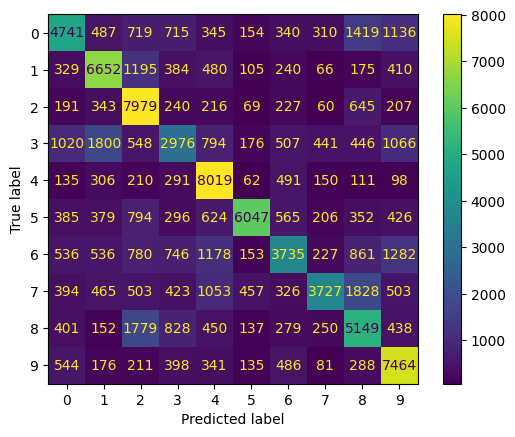

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

actual_class = df_yahoo_reduced["class"]
predicted_class = df_transformer_classified["predicted_class"]
print("F1 score:", f1_score(actual_class, predicted_class, average="micro"))

plt.rcParams['axes.grid'] = False

confusion_matrix = confusion_matrix(actual_class, predicted_class)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, )

cm_display.plot()
plt.show()

# we are trying to beat f1 score 0.54717, which was achieved with unchainged keywords sets

This result isn't surprise, advanced SBERT model still offers best accuracy!

## Conclusion

In this document we have used lbl2vec for semantic text classification. We've used approach described in [paper](https://arxiv.org/pdf/2211.16285.pdf). Dataset used for this experiment is called Yahoo! Answers and it can be downloaded through this [link](https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M). Beside of repeating work described in paper we have applied k-means clustering to identify keywords for classes. Then we have tuned keywords to outperform paper's results. Lesson learned from this experiment could help with selection of best possible keywords to achieve great classigfication accuracy. 

To summarize our findings about perfect keyword set: 
* keep it simple, 2 or 3 keywords is enough for keywords set.
* don't use too general words which could be related to another topics. It's better select keywords specifically tangled with topic and words homogenious accross keyword set. We can separate different keywords to create more keywords sets, it's like have more subtopics related to the same topic.
* having more different sets of keywords for each topic helps with accuracy.